# Training

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, FlowMatchEulerDiscreteScheduler
from tqdm import tqdm
from accelerate import Accelerator
from pathlib import Path
from fff.data import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
import torch.nn.functional as F
from typing import Optional

In [16]:
class FlowMatchTrainingScheduler(FlowMatchEulerDiscreteScheduler):
    """Extension of FlowMatchEulerDiscreteScheduler that exposes training helpers.

    This class preserves all sampling functionality of the parent, and adds two
    helpers used during training: ``add_noise`` and ``get_velocity``. The
    implementation follows the exact discrete sigma interpolation used in the
    parent's `scale_noise`/`step` implementation.

    Important: timesteps passed to the helpers should be *indices* (int tensor)
    that index into `self.sigmas` and `self.timesteps`. This is the simplest and
    least ambiguous mapping for the discrete scheduler.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # Helper to ensure timesteps are integer indices into self.sigmas
    def _as_index(self, timesteps: torch.Tensor) -> torch.LongTensor:
        """Convert a timesteps tensor (torch) to integer indices into sigmas.

        Expected input: 1-D integer tensor with values in [0, len(sigmas)-1].
        If the input is not integral or out-of-range, this function will raise
        a ValueError. This keeps behavior explicit and avoids ambiguity with
        "continuous" timestep conventions.
        """
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor(timesteps, device=self.sigmas.device)

        t_idx = timesteps.long()
        if (t_idx < 0).any() or (t_idx >= len(self.sigmas)).any():
            raise ValueError(
                f"timesteps indices must be in [0, {len(self.sigmas)-1}] (got min {t_idx.min().item()}, max {t_idx.max().item()})"
            )
        return t_idx

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.Tensor,
    ) -> torch.FloatTensor:
        """Return the forward-interpolated sample x_t for the given timesteps.

        The scheduler uses the discrete sigma schedule `self.sigmas`. The forward
        interpolation implemented in the parent is:

            x_t = sigma_t * noise + (1 - sigma_t) * x0

        This function broadcasts sigma to match the sample shape.

        Parameters
        ----------
        original_samples: x0, shape (B, C, H, W)
        noise: epsilon, same shape as original_samples
        timesteps: integer indices tensor of shape (B,)
        """
        t_idx = self._as_index(timesteps)

        # sigmas is a 1D torch tensor on scheduler device; gather and reshape
        sigmas_t = self.sigmas.to(original_samples.device)[t_idx]
        # reshape for broadcasting to (B, 1, 1, 1...)
        shape = [sigmas_t.shape[0]] + [1] * (original_samples.dim() - 1)
        sigmas_t = sigmas_t.view(*shape)

        x_t = sigmas_t * noise + (1.0 - sigmas_t) * original_samples
        return x_t

    def get_velocity(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.Tensor,
        eps: float = 1e-12,
    ) -> torch.FloatTensor:
        """Compute the discrete flow-matching vector field target v_t.

        Using the discrete schedule, we compute x_t and x_{t+1} and then form:

            v_t = (x_{t+1} - x_t) / (sigma_{t+1} - sigma_t)

        This exactly matches the finite-difference Euler interpretation used in
        the parent's `step` function which performs:

            x_prev = x + (sigma_next - sigma) * model_output

        So during training the model should predict `v_t` such that multiplying by
        (sigma_next - sigma_t) recovers the correct update.
        """
        t_idx = self._as_index(timesteps)

        # ensure we don't sample the last index (no sigma_next) unless we clip
        max_idx = len(self.sigmas) - 1
        if (t_idx == max_idx).any():
            # If a batch contains the last index, we clamp to max_idx-1 and
            # compute target using that next step. Alternatively, you can
            # sample timesteps from [0, max_idx-1] during training to avoid
            # this branch entirely.
            t_idx = torch.clamp(t_idx, max=max_idx - 1)

        sigmas = self.sigmas.to(original_samples.device)
        sigma_t = sigmas[t_idx]
        sigma_next = sigmas[t_idx + 1]

        # Broadcast shapes
        shape = [sigma_t.shape[0]] + [1] * (original_samples.dim() - 1)
        sigma_t = sigma_t.view(*shape)
        sigma_next = sigma_next.view(*shape)

        x_t = sigma_t * noise + (1.0 - sigma_t) * original_samples
        x_next = sigma_next * noise + (1.0 - sigma_next) * original_samples

        denom = (sigma_next - sigma_t).abs()
        # protect against zero division
        denom = torch.where(denom < eps, torch.full_like(denom, eps), denom)

        v_target = (x_next - x_t) / denom
        return v_target

In [17]:
class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.shadow = {}
        self.original = {}
        # Register parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (
                    1.0 - self.decay
                ) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self, model):
        """Apply EMA weights to model."""
        for name, param in model.named_parameters():
            if name in self.shadow:
                self.original[name] = param.data.clone()
                param.data.copy_(self.shadow[name])

    def restore(self, model):
        """Restore original (non-EMA) weights."""
        for name, param in model.named_parameters():
            if name in self.original:
                param.data.copy_(self.original[name])
        self.original = {}

In [18]:
def train_ct_ddpm(
    dataset_config,
    image_size=384,
    batch_size=16,
    num_epochs=5,
    learning_rate=2e-4,
    save_dir="./flowmatching-chexpert",
    num_train_timesteps=1000,
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    # Load dataset
    train_ds, _, _ = load_dataset(**dataset_config)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
    )

    # Define UNet
    model = UNet2DModel(
        sample_size=image_size,
        in_channels=1,
        out_channels=1,
        layers_per_block=2,             # two residual blocks per level
        block_out_channels=(64, 128, 128, 256),  # channel widths
        down_block_types=(
            "DownBlock2D",      # 384 -> 192
            "DownBlock2D",      # 192 -> 96
            "DownBlock2D",      # 96 -> 48
            "AttnDownBlock2D",  # 48 -> 24 (adds attention at bottleneck)
        ),
        up_block_types=(
            "AttnUpBlock2D",    # 24 -> 48
            "UpBlock2D",        # 48 -> 96
            "UpBlock2D",        # 96 -> 192
            "UpBlock2D",        # 192 -> 384
        ),
        norm_num_groups=32,
    )

    print(
        "Model parameters:",
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )

    # Noise scheduler
    noise_scheduler = FlowMatchTrainingScheduler()
    noise_scheduler.set_begin_index()

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=0
    )
    # Prepare with accelerator
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
    model.train()
    ema = EMA(model, decay=0.999)

    loss_history = []
    for epoch in range(num_epochs):
        pbar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True
        )
        for batch in pbar:
            clean_images = batch[0].reshape(batch_size, 1, image_size, image_size).to(device)
    
            # Sample t
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (clean_images.shape[0],),
                device=clean_images.device,
            ).long()
            
            # Sample noise
            noise = torch.randn_like(clean_images)
            
            # Get scheduler coefficients
             = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            # Build noisy image according to FM interpolation
            noisy_images = c_skip * clean_images + c_in * noise
            
            # Correct flow-matching velocity target
            v_target = c_noise * noise        # <-- THIS is the correct target
            
            # Model prediction
            v_pred = model(noisy_images, timesteps).sample
            
            loss = nn.MSELoss()(v_pred, v_target)
            loss_history.append(loss.item())
            accelerator.backward(loss)
            # gradient clipping
            accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()
            ema.update(model)
            optimizer.zero_grad()

            pbar.set_postfix(loss=np.mean(loss_history[-100:]))

        # Save model after each epoch
        if accelerator.is_main_process:
            ema.apply_shadow(model)
            # Now sample or save model here
            model.save_pretrained(Path(save_dir) / f"epoch_{epoch+1}")
            ema.restore(model)

    print("✅ Training complete.")

In [11]:
dataset_config = {
    "name": "chexpert",
    "root": "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-chexpert",
    "patchsize": None,
    "resize_to": 384,
    "to_grayscale": True,
}
train_ct_ddpm(dataset_config)


/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model parameters: 18202497


Epoch 1/5:   0%|          | 0/10745 [00:00<?, ?it/s]


AttributeError: 'FlowMatchEulerDiscreteScheduler' object has no attribute 'get_scalings_for_boundary_condition'

# Validation

In [6]:
from diffusers import UNet2DModel, DDPMScheduler, DPMSolverMultistepScheduler, FlowMatchEulerDiscreteScheduler
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None].to(device)
std = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None].to(device)

def normalize(img, value_range=[0, 1]):
    #Bring to 0, 1
    img = (img + value_range[0])/(value_range[1] - value_range[0])
    img = (img - mean) / std
    return img

def denormalize(img, clamp=True, value_range=[0, 1]):
    img = img * std + mean
    # Bring into value_range
    img = img*(value_range[1] - value_range[0]) + value_range[0]
    if clamp:
        img = torch.clamp(img, *value_range)
    return img

In [27]:
model = UNet2DModel.from_pretrained("diffusion-chexpert-cifar-scheduler/epoch_5").to(device)
model.eval()

# Load scheduler (make sure it's consistent with training)
scheduler = DDPMScheduler(clip_sample=False, variance_type="fixed_large")
# Sampling config
num_inference_steps = 100  # Faster than training time
scheduler.set_timesteps(num_inference_steps)

# Sample shape: (B, C, H, W)
image_size = model.config.sample_size
batch_size = 4
samples = torch.randn((batch_size, 1, image_size, image_size)).to(device)

# Run reverse diffusion
with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict noise
        noise_pred = model(samples, t).sample
        if torch.isnan(noise_pred).any():
            print(f"NaN in noise_pred at t={t}")
        # Denoise step
        samples = scheduler.step(noise_pred, t, samples).prev_sample

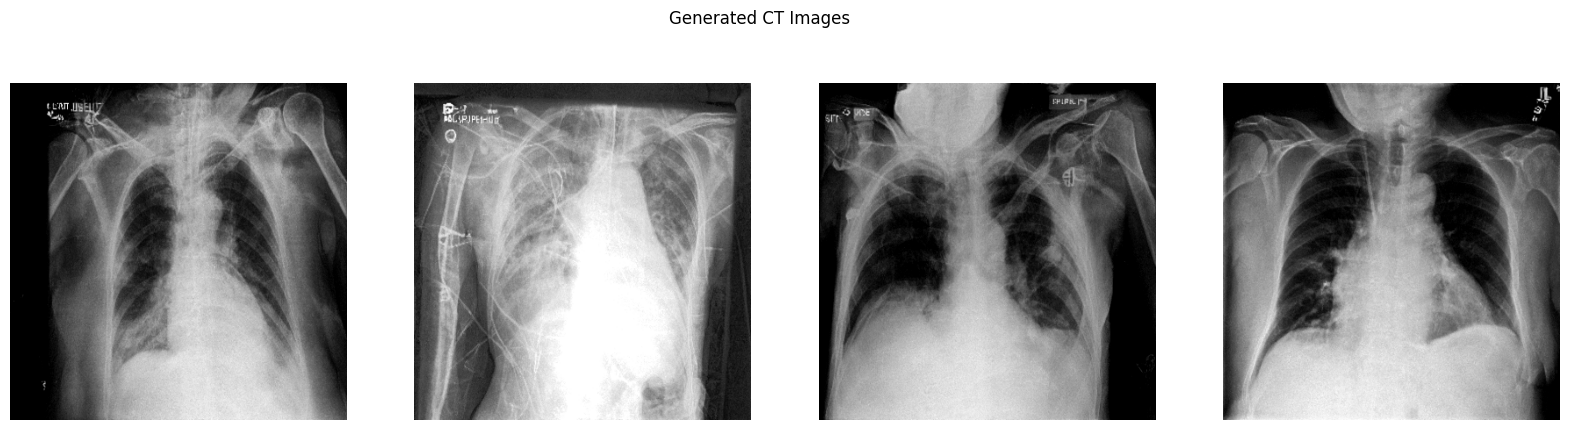

In [28]:
samples_norm = denormalize(samples)
samples_norm = samples_norm.cpu().numpy()
# normalize

# Plot
fig, axs = plt.subplots(1, batch_size, figsize=(20, 5))
for i in range(batch_size):
    axs[i].imshow(samples_norm[i, 0], cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
plt.suptitle("Generated CT Images")
plt.show()

In [11]:
model = UNet2DModel.from_pretrained("flowmatching-chexpert/epoch_5").to(device)
model.eval()

# Load scheduler (make sure it's consistent with training)
scheduler = FlowMatchEulerDiscreteScheduler()
# Sampling config
num_inference_steps = 100  # Faster than training time
scheduler.set_timesteps(num_inference_steps)
scheduler.set_begin_index()

# Sample shape: (B, C, H, W)
image_size = model.config.sample_size
batch_size = 4
samples = torch.randn((batch_size, 1, image_size, image_size)).to(device)
# Run reverse diffusion
with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict noise
        v_pred = model(samples, t).sample
        if torch.isnan(v_pred).any():
            print(f"NaN in noise_pred at t={t}")
        # Denoise step
        samples = samples - v_pred*(1/len(scheduler.timesteps))

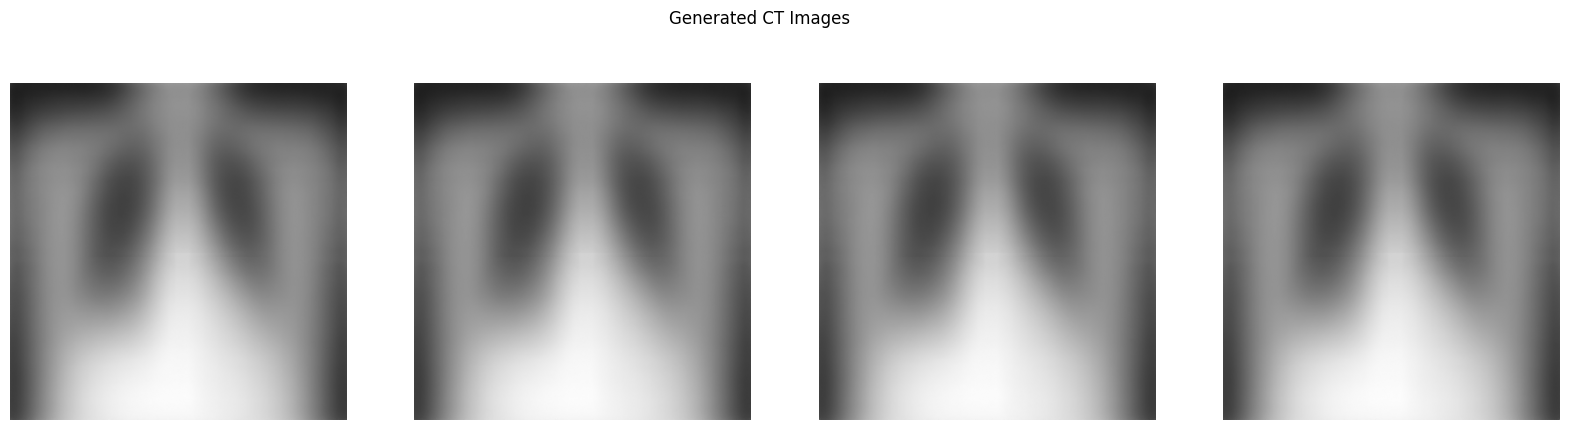

In [12]:
samples_norm = denormalize(samples)
samples_norm = samples_norm.cpu().numpy()
# normalize

# Plot
fig, axs = plt.subplots(1, batch_size, figsize=(20, 5))
for i in range(batch_size):
    axs[i].imshow(samples_norm[i, 0], cmap="gray", vmin=0, vmax=1)
    axs[i].axis("off")
plt.suptitle("Generated CT Images")
plt.show()